# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

Here we show that the calculated forward gravity of 2 sets of layers of absolute densities is identical to using the density contrasts across each surface.
<img src="../figures/absolute_vs_density_contrasts_2surfaces.svg" width="1000"/>

## Get sample data

Ice surface and bed from Bedmap2

returning grid with new region and/or registration, same spacing
returning grid with new region and/or registration, same spacing


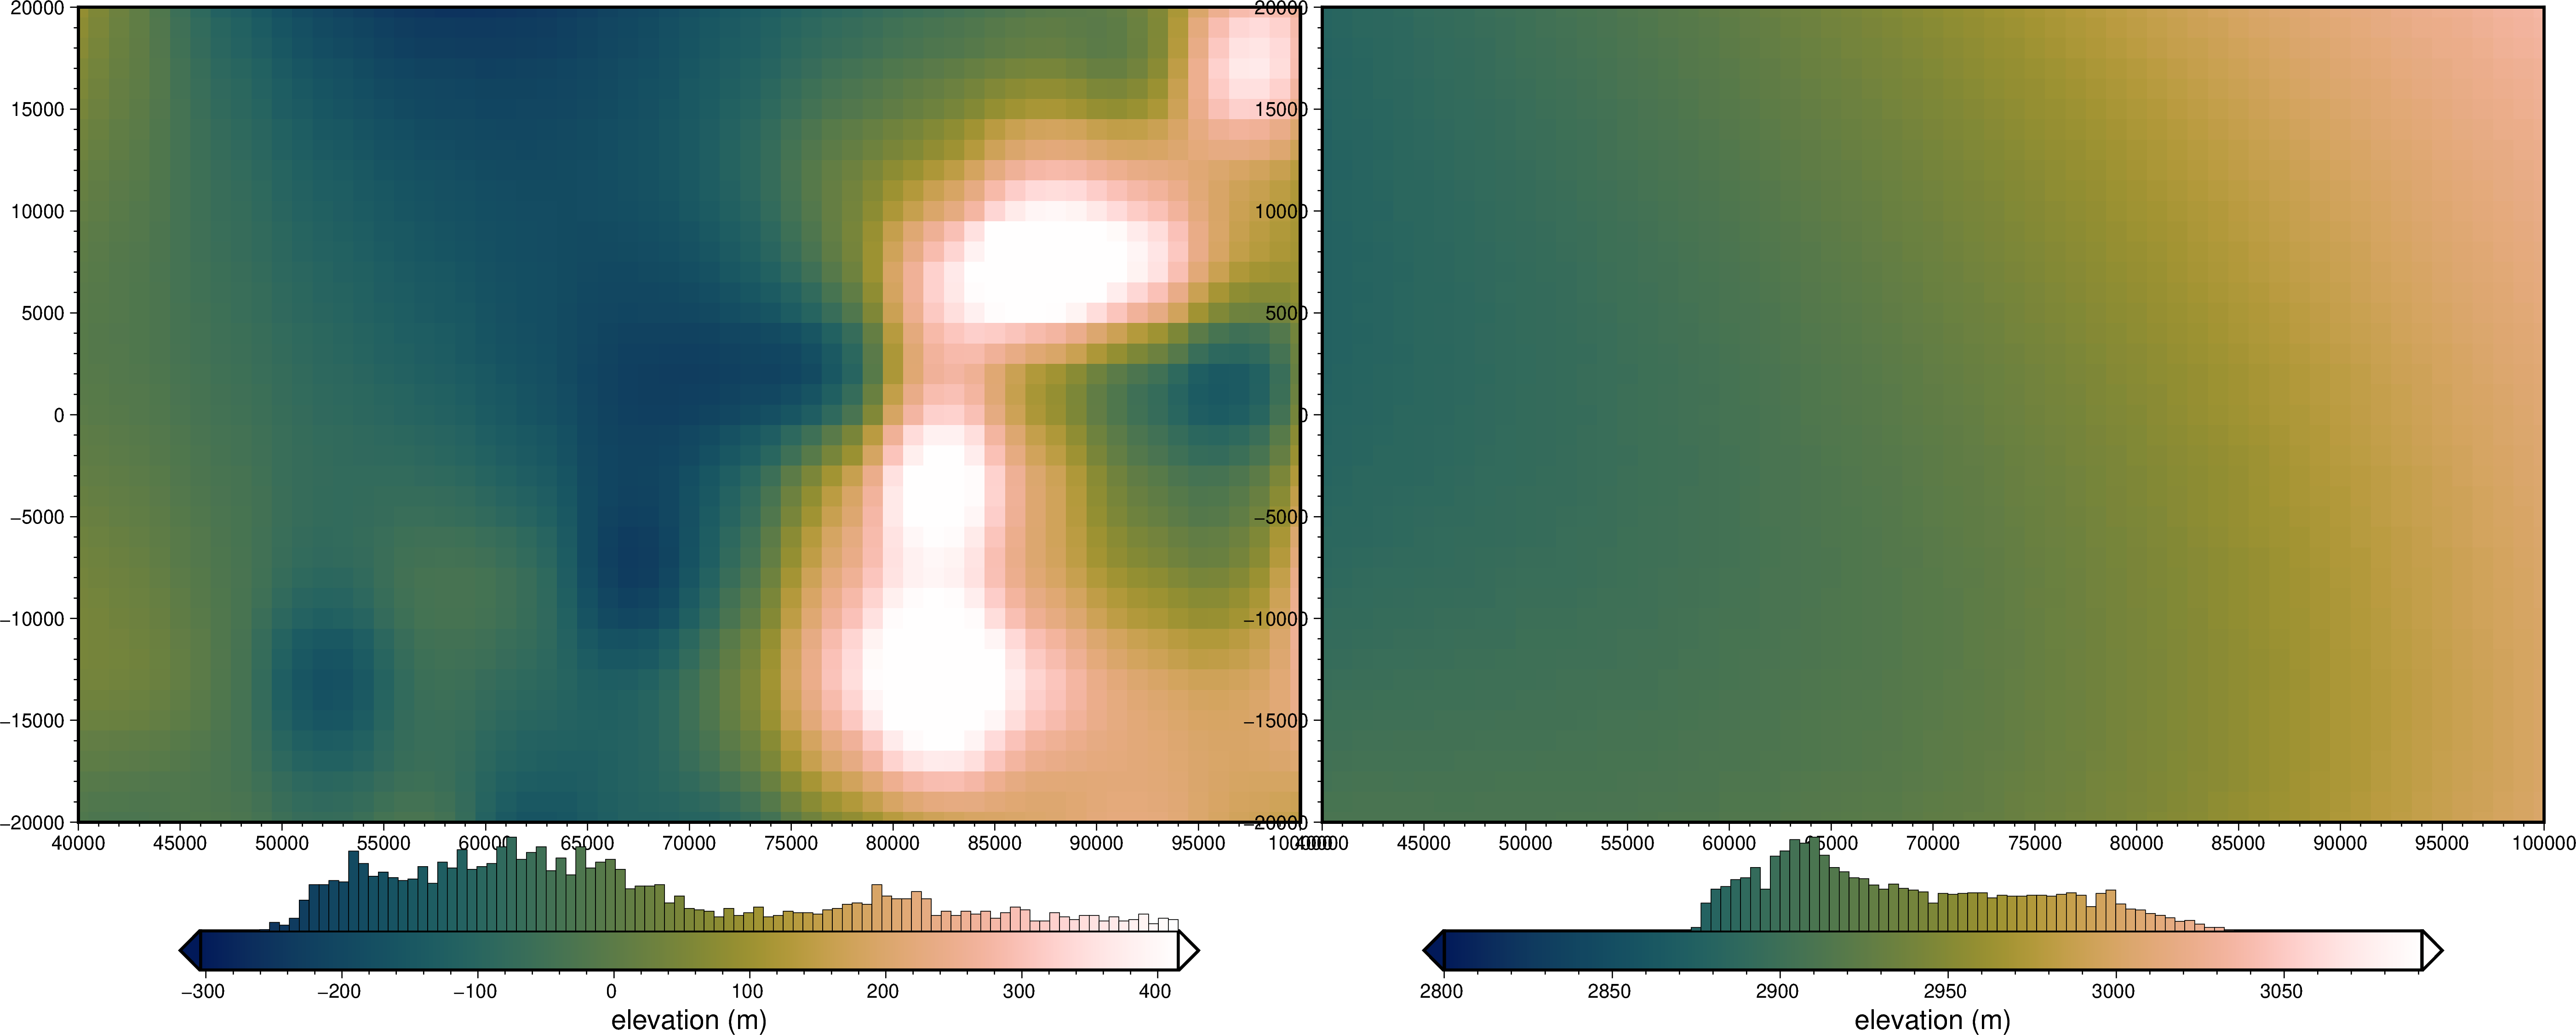

(1000.0, [0.0, 140000.0, -60000.0, 60000.0], -390.0, 612.0, 'g')

In [6]:
spacing = 1e3

inner_region = [40e3, 100e3, -20e3, 20e3]

buffer_region = utils.alter_region(inner_region, buffer=40e3)[1]

bed = fetch.bedmap2(
    layer="bed",
    region=buffer_region,
    spacing=spacing,
)
surface = fetch.bedmap2(
    layer="surface",
    region=buffer_region,
    spacing=spacing,
)
fig = maps.plot_grd(
    bed,
    inset=False,
    titles="Bed",
    cbar_label="elevation (m)",
    # show_region=inner_region,
    region=inner_region,
    cmap="batlowW",
    hist=True,
    # shading=True,
    robust=True,
    frame=True,
)
fig = maps.plot_grd(
    surface,
    inset=False,
    titles="Surface",
    cbar_label="elevation (m)",
    # show_region=inner_region,
    region=inner_region,
    cmap="batlowW",
    hist=True,
    # shading=True,
    robust=True,
    frame=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

utils.get_grid_info(bed)

## create observation points

In [4]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing * 2,
    extra_coords=3e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)
observation_points

(2000.0, [40000.0, 100000.0, -20000.0, 20000.0], 3000.0, 3000.0, 'g')


,northing,easting,upward
0,-20000.0,40000.0,3000.0
1,-20000.0,42000.0,3000.0
2,-20000.0,44000.0,3000.0
3,-20000.0,46000.0,3000.0
4,-20000.0,48000.0,3000.0
...,...,...,...
646,20000.0,92000.0,3000.0
647,20000.0,94000.0,3000.0
648,20000.0,96000.0,3000.0
649,20000.0,98000.0,3000.0


# Absolute Densities

In [23]:
air_prisms = inv_utils.grids_to_prisms(
    surface,
    surface.values.max(),
    density=1,
    input_coord_names=["x", "y"],
)

ice_prisms = inv_utils.grids_to_prisms(
    surface,
    bed,
    density=917,
    input_coord_names=["x", "y"],
)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [ice_prisms, bed_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                   | 0/651 [00:00<?, ?it/s]

  0%|                                                   | 0/651 [00:00<?, ?it/s]

  0%|                                                   | 0/651 [00:00<?, ?it/s]

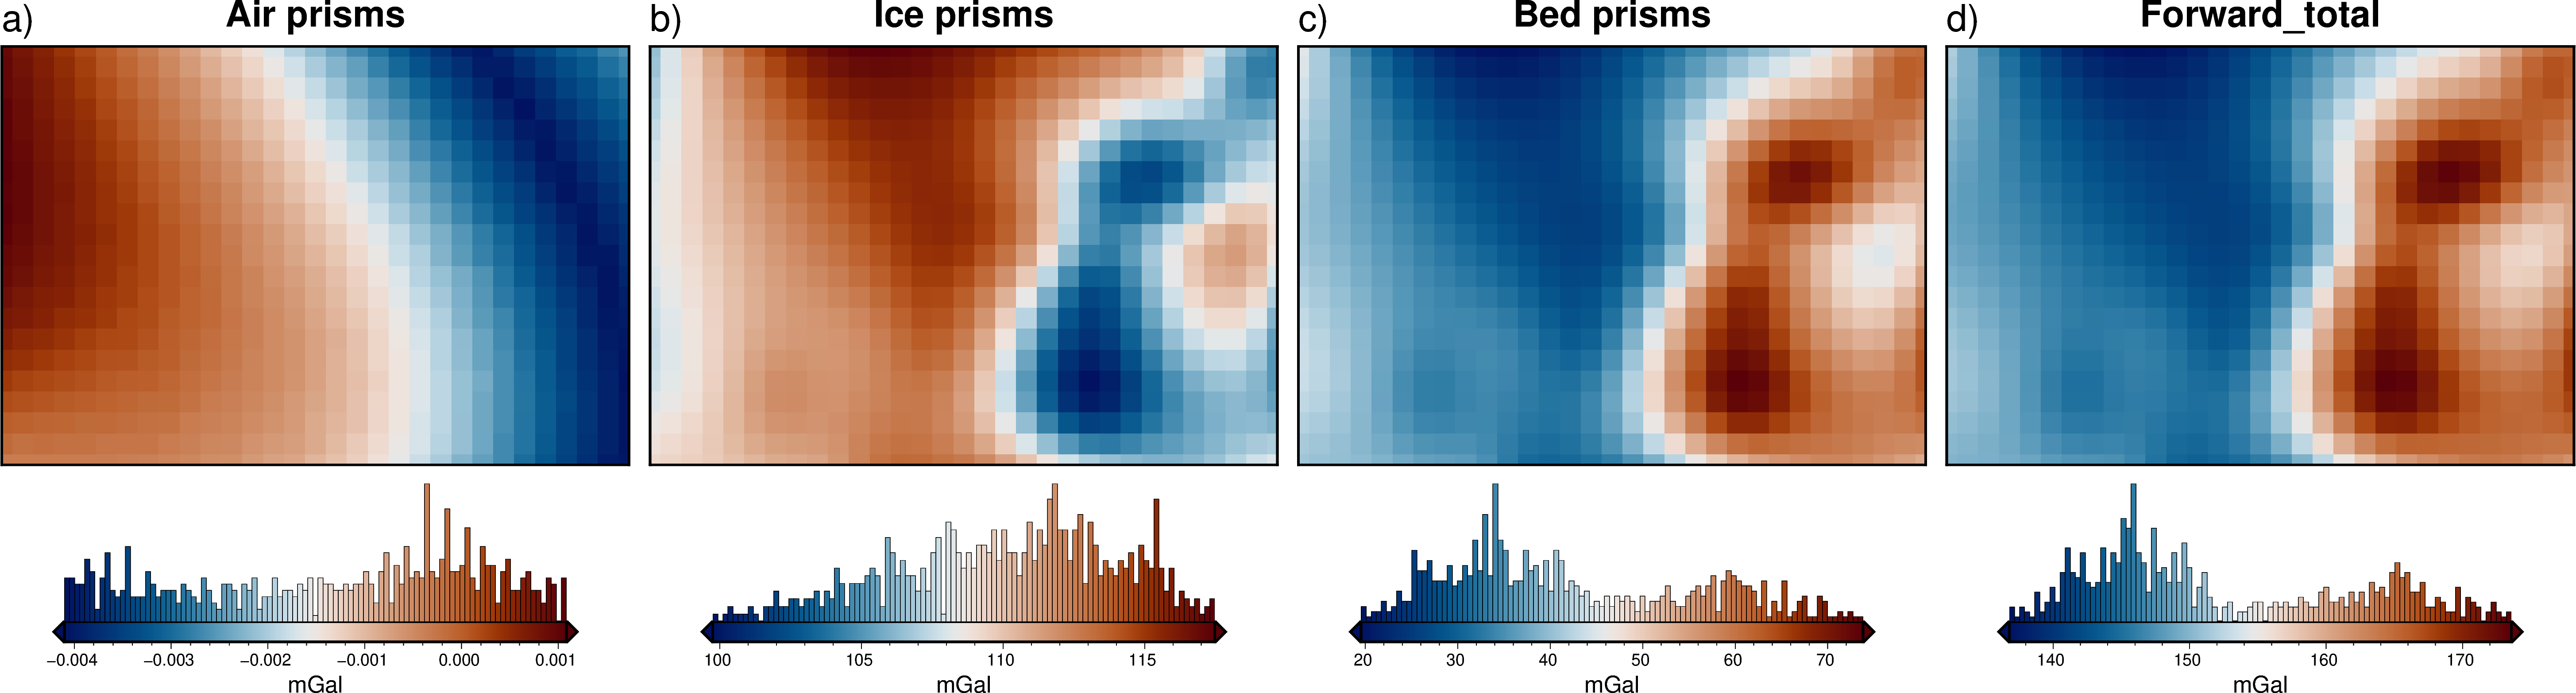

In [24]:
forward_absolute, df = inv_utils.forward_grav_of_prismlayer(
    [air_prisms, ice_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Air prisms", "Ice prisms", "Bed prisms"],
    # remove_mean=True,
    progressbar=True,
)

## Density contrasts

In [13]:
density_contrast = 917 - 1
zref = surface.values.mean()
density = xr.where(surface >= zref, density_contrast, -density_contrast)

surface_prisms = inv_utils.grids_to_prisms(
    surface,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)

density_contrast = 2670 - 917
zref = bed.values.mean()
density = xr.where(bed >= zref, density_contrast, -density_contrast)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [surface_prisms, bed_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                   | 0/651 [00:00<?, ?it/s]

  0%|                                                   | 0/651 [00:00<?, ?it/s]

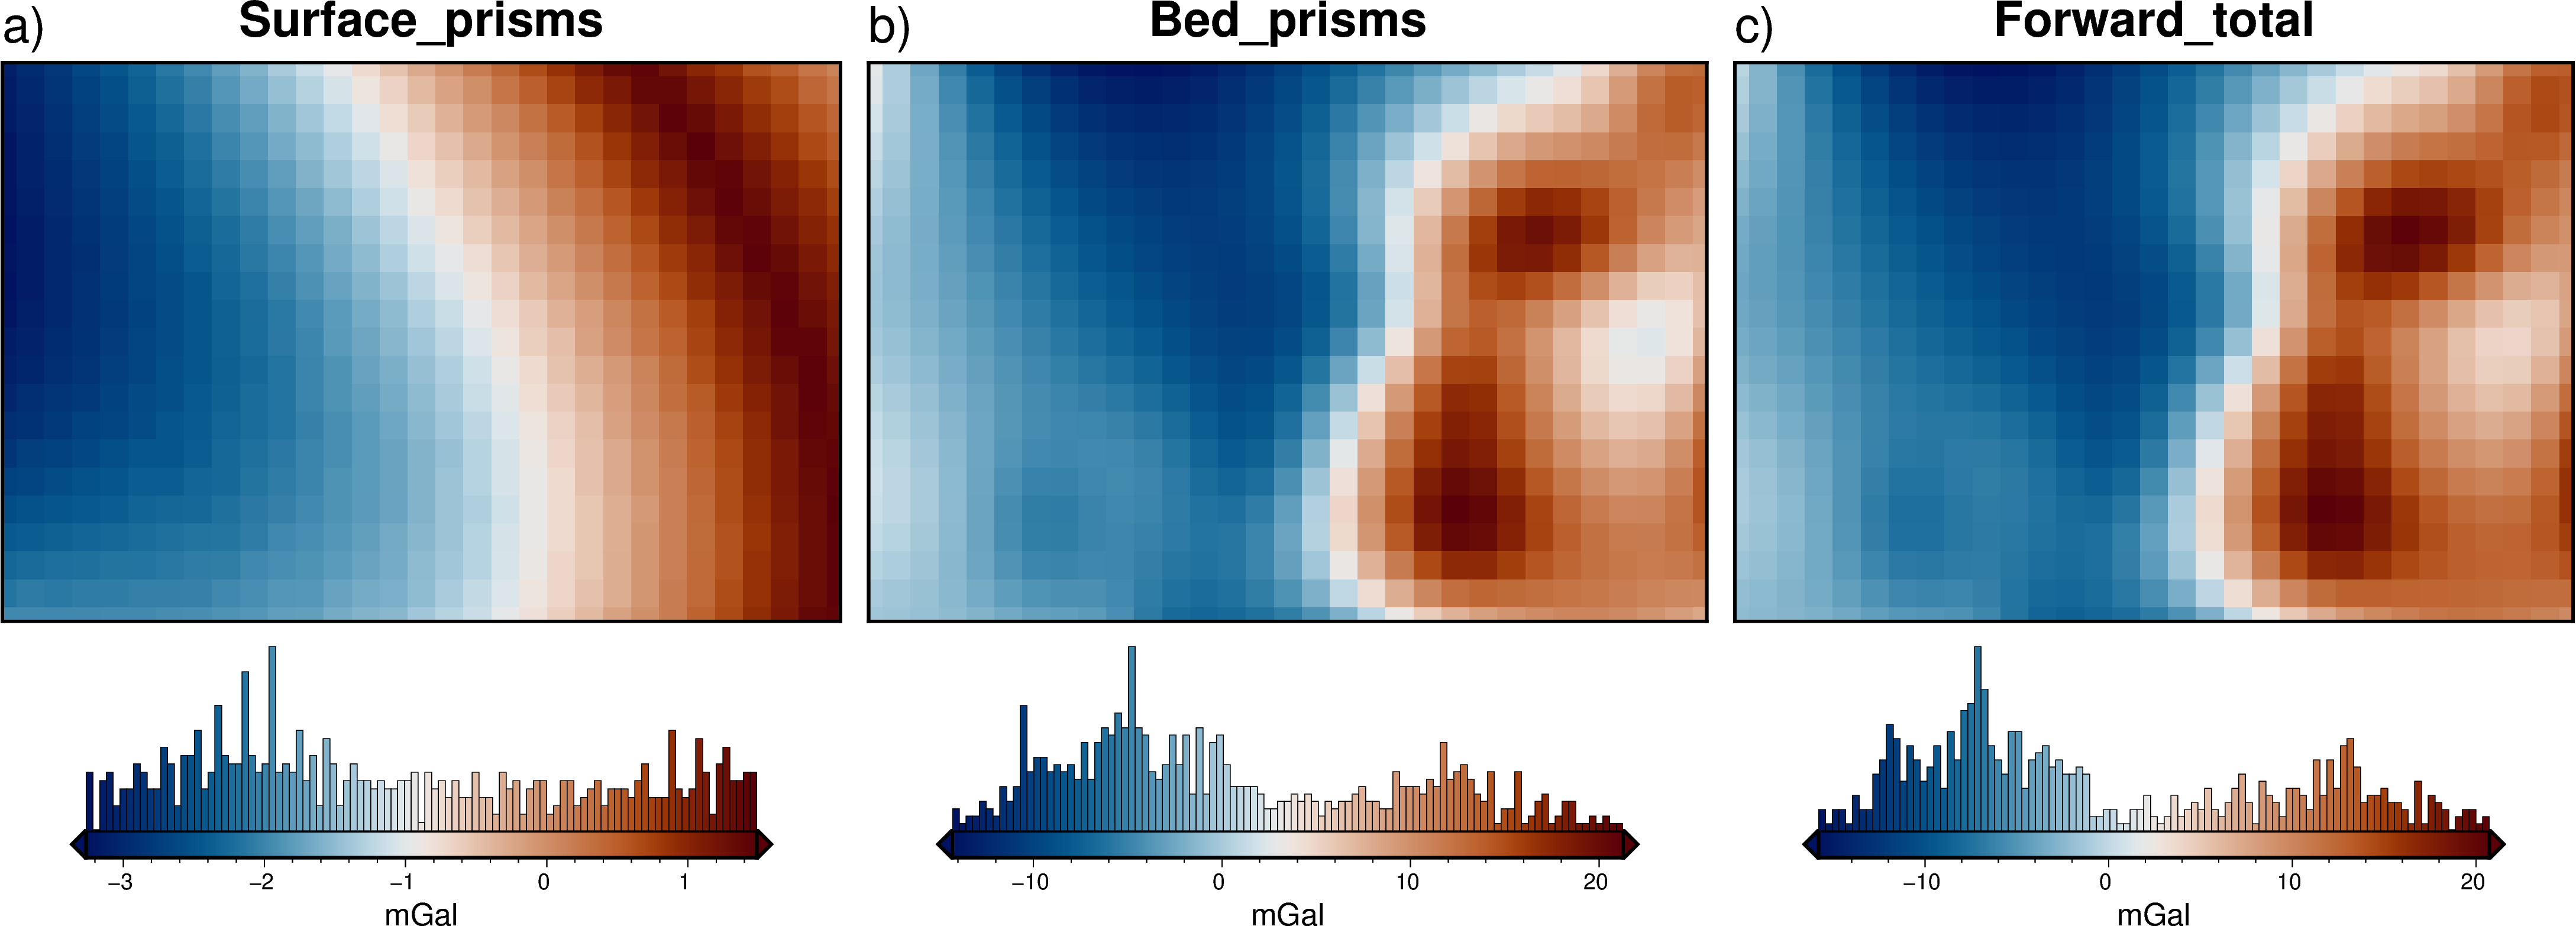

In [14]:
constrasts, df = inv_utils.forward_grav_of_prismlayer(
    [surface_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["surface_prisms", "bed_prisms"],
    remove_mean=True,
    progressbar=True,
)

In [16]:
contrasts

<xarray.Dataset>
Dimensions:         (northing: 21, easting: 31)
Coordinates:
  * northing        (northing) float64 -2e+04 -1.8e+04 ... 1.8e+04 2e+04
  * easting         (easting) float64 4e+04 4.2e+04 4.4e+04 ... 9.8e+04 1e+05
Data variables:
    upward          (northing, easting) float64 3e+03 3e+03 ... 3e+03 3e+03
    surface_prisms  (northing, easting) float64 -1.965 -1.964 ... 0.2601 0.1071
    bed_prisms      (northing, easting) float64 -0.2537 -0.526 ... 12.75 13.0
    forward_total   (northing, easting) float64 -2.219 -2.49 ... 13.01 13.1

## Compare forward gravities

In [17]:
forward_absolute

<xarray.Dataset>
Dimensions:        (northing: 21, easting: 31)
Coordinates:
  * northing       (northing) float64 -2e+04 -1.8e+04 -1.6e+04 ... 1.8e+04 2e+04
  * easting        (easting) float64 4e+04 4.2e+04 4.4e+04 ... 9.8e+04 1e+05
Data variables:
    upward         (northing, easting) float64 3e+03 3e+03 3e+03 ... 3e+03 3e+03
    Ice prisms     (northing, easting) float64 109.2 109.4 109.6 ... 104.7 104.3
    Bed prisms     (northing, easting) float64 40.72 40.34 40.01 ... 60.56 60.91
    forward_total  (northing, easting) float64 149.9 149.7 149.6 ... 165.2 165.2

In [19]:
plot_type = "xarray"
# plot_type = 'pygmt'

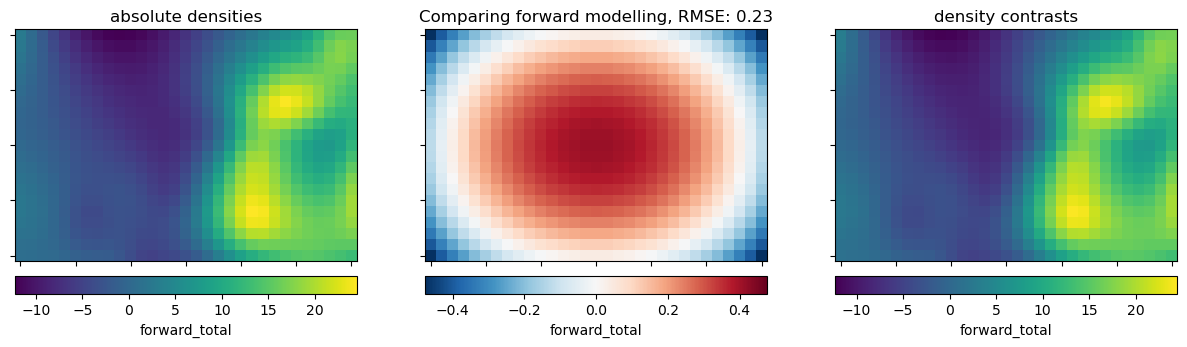

In [25]:
grids = utils.grd_compare(
    forward_absolute.forward_total - np.nanmedian(forward_absolute.forward_total),
    contrasts.forward_total - np.nanmedian(contrasts.forward_total),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrasts",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)